# Running our trained cartoongan model locally

In [2]:
%config Completer.use_jedi=False

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading the required libraries

In [3]:
import sys
sys.path.append("../")
from io import BytesIO

In [34]:
import base64
import requests
import torch
import os
import numpy as np
import argparse
from PIL import Image
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.utils as vutils
from network.Transformer import Transformer

from tqdm import tqdm_notebook
from test_from_code import transform

### Loading models locally

In [5]:
styles = ["Hosoda", "Hayao", "Shinkai", "Paprika"]

models = {}

for style in tqdm_notebook(styles):
    model = Transformer()
    model.load_state_dict(torch.load(os.path.join("./../pretrained_models/", style + '_net_G_float.pth')))
    model.eval()
    models[style] = model

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [6]:
### change this path to test one of the four models locally
path = "../../test-images/paris.jpg"

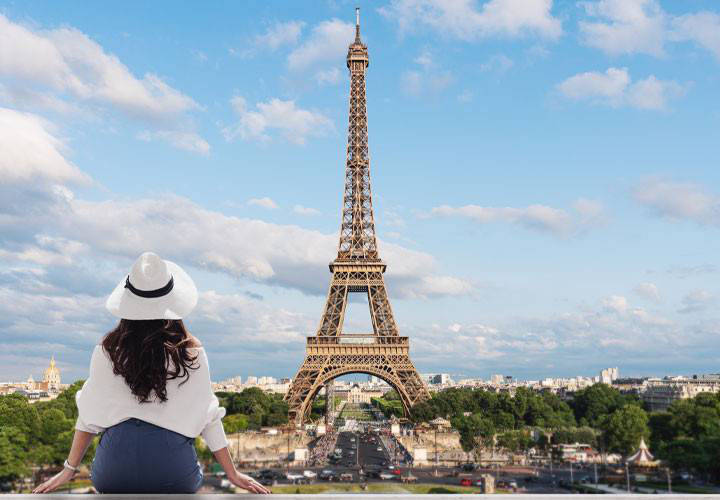

In [7]:
img = Image.open(path)
img

In [8]:
### pick a style in : ["Hosoda", "Hayao", "Shinkai", "Paprika"]
style = "Hosoda"

In [9]:
### choose a load_size, the higher the better are the results, but the longer is the transformation
load_size = 300

In [10]:
%%time
output300 = transform(models, style, path, load_size)

input shape torch.Size([1, 3, 208, 300])
inference time took 1.3854577541351318 s
Wall time: 1.48 s


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


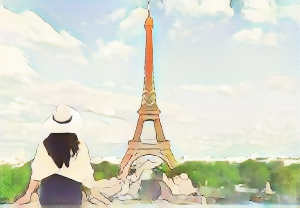

In [11]:
output300

In [12]:
%%time
### load_size to 450
output450 = transform(models, style, path, load_size=450)

input shape torch.Size([1, 3, 312, 450])
inference time took 2.6659979820251465 s
Wall time: 2.69 s


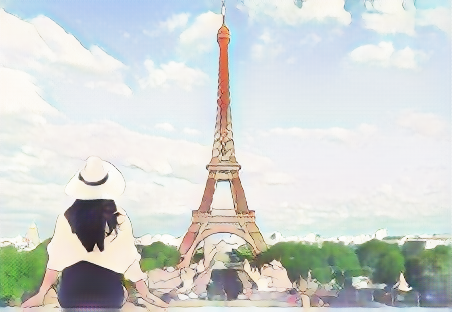

In [13]:
output450

In [14]:
%%time
### load_size to 650
output650 = transform(models, style, path, load_size=650)

input shape torch.Size([1, 3, 451, 650])
inference time took 5.608004093170166 s
Wall time: 5.65 s


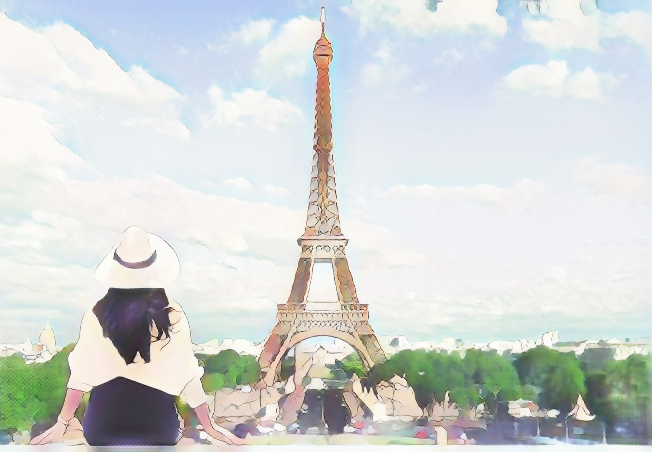

In [15]:
output650

## Model Deployed on AWS S3

### Using boto3 package to interact with AWS

In [17]:
import boto3

#### Configure AWS using Boto3

In [25]:
with open("secret.txt")as f:
    data = f.readlines()
aws_accesskey = data[0].strip('\n')
aws_secretkey = data[1].strip('\n')
    
# print(aws_accesskey,aws_secretkey)    

client = boto3.client(
    's3',
    aws_access_key_id=aws_accesskey,
    aws_secret_access_key=aws_secretkey,
    
)
client

#### Viewing buckets created

In [26]:
s3 = boto3.resource('s3')

for bucket in s3.buckets.all():
    print(bucket.name)

cartoonmini


#### Loading models from the "cartoonmini" bucket

In [27]:
def img_to_base64_str(img):
    buffered = BytesIO()
    img.save(buffered, format="PNG")
    buffered.seek(0)
    img_byte = buffered.getvalue()
    img_str = "data:image/png;base64," + base64.b64encode(img_byte).decode()
    return img_str


def load_models(s3, bucket):

    styles = ["Hosoda", "Hayao", "Shinkai", "Paprika"]
    models = {}

    for style in styles:
        model = Transformer()
        response = s3.get_object(Bucket=bucket, Key=f"models/{style}_net_G_float.pth")
        state = torch.load(BytesIO(response["Body"].read()))
        model.load_state_dict(state)
        model.eval()
        models[style] = model

    return models


gpu = -1

s3 = boto3.client("s3")
bucket = "cartoonmini"

mapping_id_to_style = {0: "Hosoda", 1: "Hayao", 2: "Shinkai", 3: "Paprika"}

models = load_models(s3, bucket)
print(f"models loaded ...")

models loaded ...


#### Loading an image

In [28]:
path = '../../test-images/lawrence.jpg'


img = Image.open(path)
with open(path, "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read()).decode('utf-8')


data = {
    "image": encoded_string,
    "model_id": 1,
    "load_size": 500
}
# print(data)

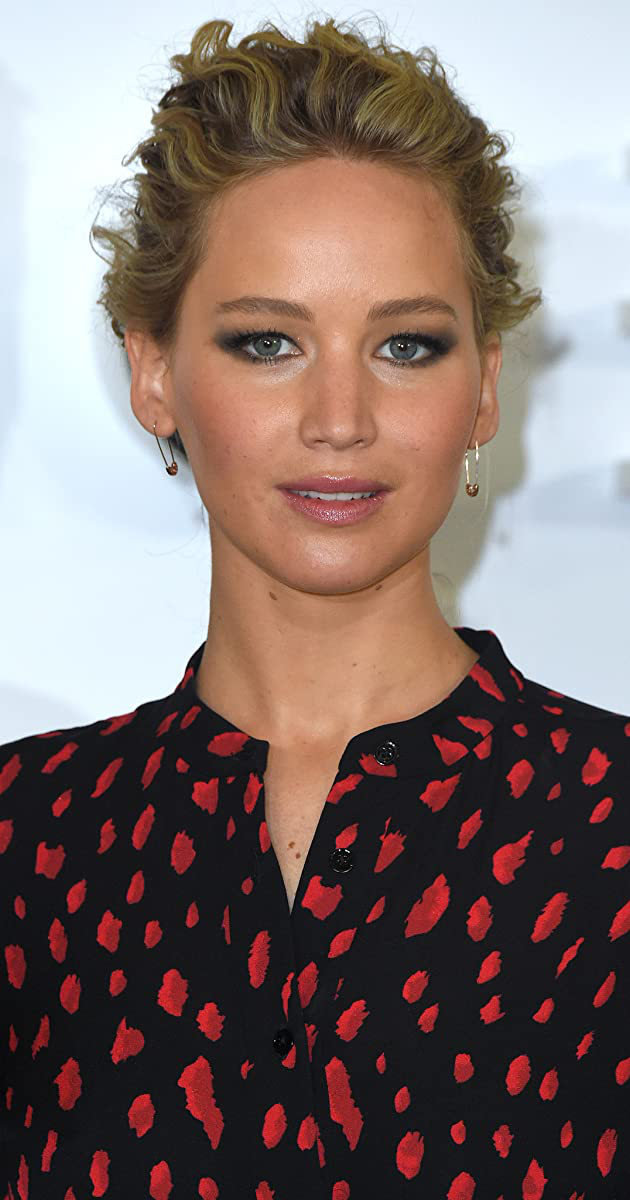

In [29]:
img

### Input a style of cartoonifier and output image size

In [30]:
style = input("Input Style:")
load_size = int(input("Input Load size:"))

Input Style:Hayao
Input Load size:400


#### Timing the model

In [31]:
%%time

output = transform(models, style, path, load_size)

input shape torch.Size([1, 3, 400, 210])
inference time took 1.6680307388305664 s
Wall time: 1.7 s


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


### Output 

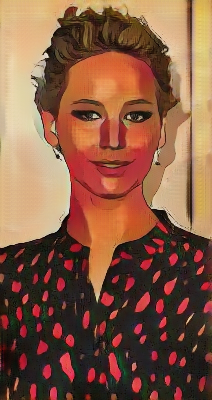

In [32]:
output